In [48]:
import numpy
from scipy.linalg import solve

In [49]:
def constructMatrix(nx, ny, sigma):
    """ Generate implicit matrix for 2D heat equation with Dirichlet BC in
    top and right and Neumann in bottom and left. 

    Uses row-major ordering.
    Assume delta = dx = dy.
    
    Parameters:
        nx - number of spatial points in x direction
        ny - number of spatial points in y direction
        sigma - alpha*dt/dx
        
    Returns:
        A - Matrix of implicit 2D heat equation
    """
    
    A = numpy.zeros(((nx-2)*(ny-2),(nx-2)*(ny-2)))
    
    rownum = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner (Dirichlet down and left)
                A[rownum,rownum] = 1/sigma+4 # Set diagonal
                A[rownum,rownum+1] = -1      # i+1
                A[rownum,rownum+nx-2] = -1   # j+1
                
            elif i==nx-2 and j==1: # Bottom right corner (Dirichlet down, Neumann right)
                A[rownum,rownum] = 1/sigma+3 # Set diagonal
                A[rownum,rownum-1] = -1      # i-1
                A[rownum,rownum+nx-2] = -1   # j+1
                
            elif i==1 and j==ny-2: # Top left corner (Neumann up, Dirichlet left)
                A[rownum,rownum] = 1/sigma+3   # Set diagonal
                A[rownum,rownum+1] = -1        # i+1
                A[rownum,rownum-(nx-2)] = -1   # j-1
                
            elif i==nx-2 and j==ny-2: # Top right corner (Neumann up and right)
                A[rownum,rownum] = 1/sigma+2   # Set diagonal
                A[rownum,rownum-1] = -1        # i-1
                A[rownum,rownum-(nx-2)] = -1   # j-1
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                A[rownum,rownum] = 1/sigma+4 # Set diagonal
                A[rownum,rownum+1] = -1      
                A[rownum,rownum+nx-2] = -1   
                A[rownum,rownum-(nx-2)] = -1 
            
            elif i==nx-2: # Right boundary (Neumann)
                A[rownum,rownum] = 1/sigma+3 
                A[rownum,rownum-1] = -1      
                A[rownum,rownum+nx-2] = -1   
                A[rownum,rownum-(nx-2)] = -1 
                
            elif j==1: # Bottom boundary (Dirichlet)
                A[rownum,rownum] = 1/sigma+4 
                A[rownum,rownum+1] = -1      
                A[rownum,rownum-1] = -1      
                A[rownum,rownum+nx-2] = -1   
                
            elif j==ny-2: # Top boundary (Neumann)
                A[rownum,rownum] = 1/sigma+3 # Set diagonal
                A[rownum,rownum+1] = -1      
                A[rownum,rownum-1] = -1      
                A[rownum,rownum-(nx-2)] = -1 
                
            # Interior points
            else:
                A[rownum,rownum] = 1/sigma+4 # Set diagonal
                A[rownum,rownum+1] = -1     
                A[rownum,rownum-1] = -1      
                A[rownum,rownum+nx-2] = -1   
                A[rownum,rownum-(nx-2)] = -1 
                
            rownum += 1
    
    return A 

In [50]:
def generateRHS(nx, ny, sigma, T, T_bc):
    """Generate right-hand side for 2D implicit heat equation with Dirichlet
        BC in bottom, left and Neumann BC in top, right.
        
        Assume delta = dx = dy, Neumann BCs = 0, constant Dirichlet BC
        
        Parameters:
            nx - number of spatial points in x direction
            ny - number of spatial points in y direction
            sigma - alpha*dt/dx
            T - Temp. in current time step
            T_bc - Temp. in Dirichlet BC
            
        Returns:
            RHS - Right hand side of 2D implicit heat equation.
        """
    RHS = numpy.zeros((nx-2)*(ny-2))
    
    rownum = 0
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            #Corners
            if i==1 and j==1: #Bottom left
                RHS[rownum] = T[j,i]*1/sigma + 2*T_bc
                
            elif i==nx-2 and j==1:
                RHS[rownum] = T[j,i]*(1/sigma)+T_bc
                
            elif i==1 and j==ny-2:
                RHS[rownum] = T[j,i] *1/sigma + T_bc
            
            elif i==nx-2 and j==ny-2:
                RHS[rownum] = T[j,i]*1/sigma
                
            #Sides
            elif i==1:
                RHS[rownum] = T[j,i]*1/sigma + T_bc
            elif i==nx-2:
                RHS[rownum] = T[j,i]*1/sigma
            elif j==1:
                RHS[rownum] = T[j,i]*1/sigma + T_bc
            elif j==ny-2:
                RHS[rownum] = T[j,i]*1/sigma
                
            #interior points
            else:
                RHS[rownum] = T[j,i]*1/sigma
                
            rownum +=1
            
    return RHS
                

In [51]:
def map_1Dto2D(nx, ny, T_1D, T_bc):
    T = numpy.zeros((ny, nx))
    
    rownum = 0
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            T[j,i] = T_1D[rownum]
            rownum +=1
    #BCs        
    T[0,:] = T_bc
    T[:,0] = T_bc
    T[-1,:] = T[-2,:]
    T[:,-1] = T[:,-2]
    
    return T    

In [52]:
def btcs_2D(T, A, nt, sigma, T_bc, nx, ny, dt):
    """Advnaces diffusion equation in time with backward Euler
    
    Parameters:
        T - initial temp. profile
        A - Matrix with discretized diffusion equation
        nt - time steps
        sigma - alpha*dt/dx**2
        T_bc - Dirichlet boundary condition
        nx - Discretization points in x
        ny - Discretization points in y
        
    Returns:
        T - temp profile after nt time steps
    """
    
    j_mid = (numpy.shape(T)[0])/2
    i_mid = (numpy.shape(T)[1])/2
    
    for t in range(nt):
        Tn = T.copy()
        b = generateRHS(nx, ny, sigma, Tn, T_bc)
        #Use numpy.linalg.solve
        T_interior = solve(A,b)
        T = map_1Dto2D(nx, ny, T_interior, T_bc)
        
        #check if T=70C
        if T[j_mid, i_mid] >= 70:
            print("Center of plate reached 70C at time {0:.2f}s, timestep {1:d}".format(dt*t, t))
            break
        
    if T[j_mid, i_mid] < 70:
        print("Center has not reached 70C, T={0:.2f}".format(T[j_mid, i_mid]))
           
    return T

In [53]:
alpha = 1e-4

L = 1.0e-2
H = 1.0e-2

nx = 21
ny = 21
nt = 300

dx = L/(nx-1)
dy = H/(nx-1)

x = numpy.linspace(0, L, nx)
y = numpy.linspace(0, H, ny)

T_bc = 100
Ti = numpy.ones((ny, nx))*20
Ti[0,:] = T_bc
Ti[:,0] = T_bc

In [71]:
sigma = 3
A = constructMatrix(nx, ny, sigma)

In [72]:
dt = sigma*min(dx, dy)**2/alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)

/home/randy/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/randy/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Center of plate reached 70C at time 0.16s, timestep 21


In [73]:
print(A)
numpy.shape(A)

[[ 4.33333333 -1.          0.         ...,  0.          0.          0.        ]
 [-1.          4.33333333 -1.         ...,  0.          0.          0.        ]
 [ 0.         -1.          4.33333333 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  3.33333333 -1.          0.        ]
 [ 0.          0.          0.         ..., -1.          3.33333333 -1.        ]
 [ 0.          0.          0.         ...,  0.         -1.          2.33333333]]


(361, 361)

In [74]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

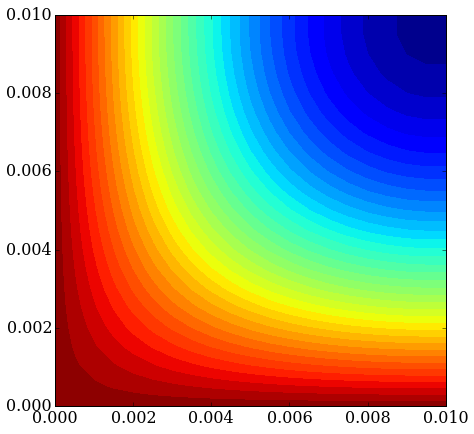

In [76]:
mx, my = numpy.meshgrid(x, y)
pyplot.figure(figsize=(7,7))
pyplot.contourf(my,mx,T,50);